In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
#importing data and looking at first few rows
df1 = pd.read_csv('../data/df1.csv').drop('Unnamed: 0', axis = 1)
df1.head(2)

,subreddit,title,title_length,title_word_count
0,datingoverthirty,why is dating so fucking hard?,30,6
1,datingoverthirty,Trust Issues making me (30f) anxious around my...,55,10


In [3]:
#Converting the subreddit column to binary
df1['subreddit'] = np.where(df1['subreddit'] == 'datingoverthirty',1,0)

In [4]:
df1.head(2)

,subreddit,title,title_length,title_word_count
0,1,why is dating so fucking hard?,30,6
1,1,Trust Issues making me (30f) anxious around my...,55,10


In [5]:
X = df1['title']
y = df1['subreddit']

In [6]:
#Baseline accuracy to compare if our model is better than null model
y.value_counts(normalize = True)

1    0.661101
0    0.338899
Name: subreddit, dtype: float64

In [7]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    stratify=y,
                                                    random_state=42)

In [8]:
#Instantiate a countervectorizer and transform
cvec = CountVectorizer(stop_words = 'english')
cvec.fit(X_train)
X_train = cvec.transform(X_train)
X_test = cvec.transform(X_test)
print(X_train.shape)

(5366, 4519)


In [9]:
#converting X_train to Dataframe to visualize it
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names())

In [10]:
X_train_df.head(3)

,000,0562984145,10,100,100kms,101,11,12,13,14,...,zero,zest,zmf5vbxwu,zoeykelsie,zombie,zone,zoned,zoo,zroane_214,độc
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


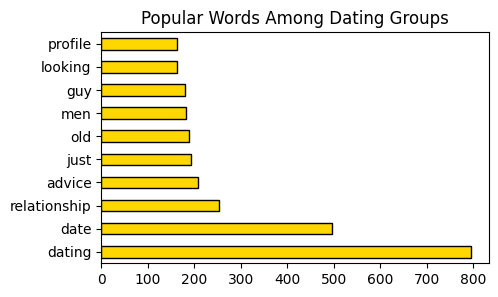

In [63]:
# Plot top occuring words
plt.figure(figsize = (5,3))
X_train_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh',
                                                             color = 'Gold',
                                                             edgecolor = 'black')
plt.title("Popular Words Among Dating Groups")
plt.savefig("../images/popularwords");

#### It appears that some of the highly used words by the dating community are date, dating, relationship, advise, old, people, looking etc

In [12]:
len(X_train_df.columns)

4519

In [13]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    stratify=y,
                                                    random_state=42)

In [14]:
#Creating a Pipeline using a countervectorizer and Multinomial Naive 
#Bayes Classifier
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [15]:
#Defining the params for our model
pipe_params = {
    'cvec__max_features': [500, 1000, 2_000, 3_000, 4_000, 5_000, 8_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2), (2,2), (2,3)]
}
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params, # what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [16]:
#Fitting the model using the above parameters
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [500, 1000, 2000, 3000, 4000,
                                                5000, 8000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2), (2, 3)]})

In [17]:
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.7743197912784197
0.662608695652174


#### The model is performing well on the train data but not performing on the test data which means the data is overfitting 

In [18]:
gs.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

<Figure size 200x200 with 0 Axes>

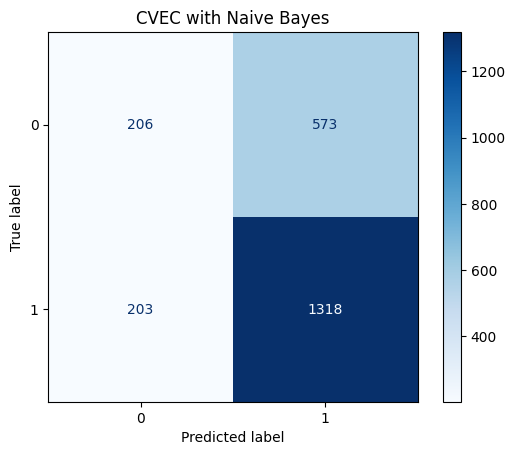

In [19]:
# Plotting a confusion matrix
plt.figure(figsize = (2,2))
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', 
                      values_format='d')
plt.title('CVEC with Naive Bayes');

In [20]:
y_preds = gs.predict(X_test)

In [21]:
#Using TFIDF this time with the below params
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2), (2,3)]}

In [22]:
# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(pipe_tvec,
                      param_grid = pipe_tvec_params,
                      cv = 5)

In [23]:
#Fitting the Model
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 3)],
                         'tvec__stop_words': [None, 'english']})

In [24]:
print(f'Training Score TFIDF : {round(gs_tvec.score(X_train, y_train),2)}')
print(f'Testing Score TFIDF : {round(gs_tvec.score(X_test, y_test),2)}')

Training Score TFIDF : 0.74
Testing Score TFIDF : 0.67


#### The model appears to be overfitting a again, it could be because the data is imalanced and the model is leaning towards the over30 group because of the underrepresentation of the over40 group

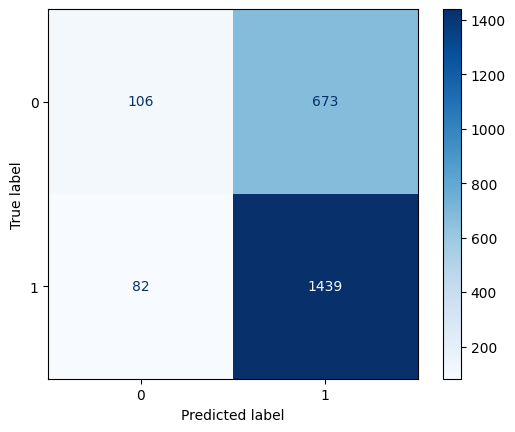

In [25]:
# plotting confusion matrix for the above model
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues');

#### From the above confusion matrix we can see that the TFIDF model predicted more false positives than the previous Countervectorizer model

In [26]:
y_preds1 = gs_tvec.predict(X_test)

In [27]:
#Using SVM to classify
# C values to GridSearch over
pgrid = {"C": np.linspace(0.0001, 2, 10)}

In [28]:
svc = SVC(gamma="scale")
pgrid = {
    'C' : np.linspace(0.0001, 5, 100),
    'gamma' : [1, 0.1, 0.01, 0.001, 0.0001], 
    'kernel' : ['rbf']
}

In [29]:
#Using TFIDF and Support Vector machines to classify
pipe_tvec1 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('svc', SVC(gamma = "scale"))
])

pipe_tvec1_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2), (1,3), (2,2), (3,3)],
    'svc__C': np.linspace(0.0001, 2, 10),
    'svc__max_iter' : 10000
}

In [30]:
#Fitting the model
pipe_tvec1.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer()), ('svc', SVC())])

In [31]:
print(f'Training Score TFIDF SVM : {round(pipe_tvec1.score(X_train, y_train), 2)}')
print(f'Testing Score TFIDF SVM : {round(pipe_tvec1.score(X_test, y_test), 2)}')

Training Score TFIDF SVM : 0.91
Testing Score TFIDF SVM : 0.67


<Figure size 100x100 with 0 Axes>

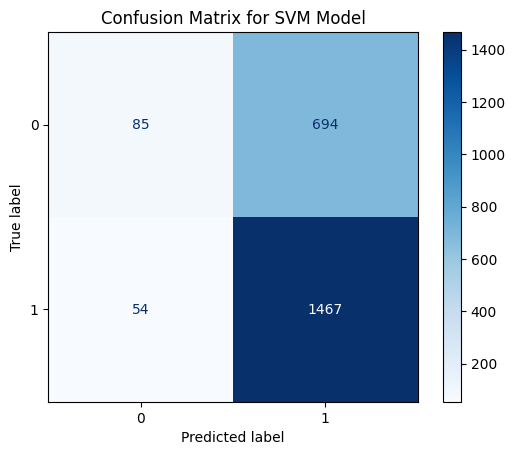

In [32]:
# plotting confusion matrix for the above model
plt.figure(figsize = (1,1))
plot_confusion_matrix(pipe_tvec1, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix for SVM Model");

In [33]:
y.value_counts(normalize = True)

1    0.661101
0    0.338899
Name: subreddit, dtype: float64

In [34]:
y_pred2 = pipe_tvec1.predict(X)

In [35]:
df1['y_pred2'] = y_pred2

In [36]:
df1['y_pred2'].value_counts(normalize = True)

1    0.803026
0    0.196974
Name: y_pred2, dtype: float64

In [37]:
accuracy_score(y, y_pred2)

0.8416384033394209

In [38]:
#Creating a Pipeline with XGBoost Classifier
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier())
])

In [39]:
pipe_params = {
    'cvec__max_features': [500, 1000, 2_000, 3_000, 4_000, 5_000, 8_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'xgb__n_estimators': [10, 100],
    'xgb__max_depth': [None, 1, 2, 3]
    
}

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid = pipe_params,# what parameters values are we searching?
                  cv = 5) # 5-fold cross-validation.

In [40]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None, gpu_id=None,
                                      

In [41]:
gs.score(X_train, y_train)

0.7554975773387999

In [42]:
gs.score(X_test, y_test)

0.6660869565217391

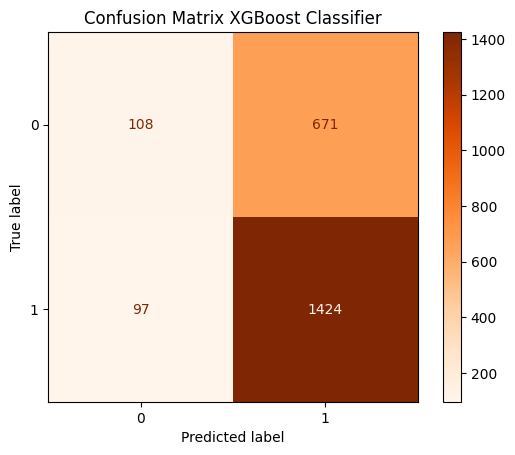

In [62]:
plot_confusion_matrix(gs, X_test, y_test, cmap = 'Oranges' )
plt.title("Confusion Matrix XGBoost Classifier")
plt.savefig('../images/confusion.jpg');

In [44]:
y_preds = gs.predict(X)

In [45]:
df1['y_preds'] = y_preds

In [46]:
df1['y_preds'].value_counts(normalize = True)

1    0.888338
0    0.111662
Name: y_preds, dtype: float64

In [47]:
accuracy_score(y, y_preds)

0.7286720584398644

In [48]:
y_preds3 = gs.predict(X_test)

In [49]:
sensitivity = recall_score(y_test, y_preds3)
sensitivity

0.9362261669953977

In [50]:
cm = confusion_matrix(y_test, y_preds3)

In [51]:
tn, fp, fn, tp = cm.ravel()
print(tn, fp,fn,tp)

108 671 97 1424


### Model Evaluation:

#### Finally used a XGBoost Classifier, the training score came down compared to the SVM model, XGBoost is also overfitting like other models. The model identified True positives but failed to identify true negatives. Again the model is leaning towards the stronger group over30 as the data is imbalanced. 

### Conclusion

I've used four models to classify, firstly I used Countervectorizer with Naive Bayes Classifier, the model returned a training score of 0.77 and the testing score of 0.66. I then used Naive Bayes with TFIDF vecorizer, then I used two more models using support vector machine and xgboost classifier which returned the results below:


- [x] Training Score Counter Vectorizer Naive Bayes : 0.77             
- [x] Testing Score Counter Vectorizer Naive Bayes : 0.66
- [x] Training Score TFIDF Naive Bayes : 0.74
- [x] Testing Score TFIDF Naive Bayes : 0.67
- [x] Training Score TFIDF SVM : 0.91
- [x] Testing Score TFIDF SVM : 0.67
- [x] Training Score CounterVectorizer, XGBoost Classifier : 0.75
- [x] Training Score CounterVectorizer, XGBoost Classifier : 0.66

All the models have more false positives except the one with Naive Bayes classifier using counter vectorizer, that model has less false positives than the other models but it has more false negatives. It is clear that the data is imbalanced. We need to find a way to balance the data by aquiring more data and analyzing emoji's and hashtags. The other reason why the models were not able to classify can be because the vocaubulary used by both over30's and over40's is similar that is why it is important to find more data, balance the data and find new ways like emoji's and hashtags to find the signals to differentiate.